In [1]:
import re
import pickle
import warnings
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from IPython.core.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.max_columns', None)
display(HTML('<style>.container{width : 100% ! important;}</style>'))

In [2]:
df = pd.read_csv('IPL 2nd Inningsv2.csv')

In [3]:
df.head()

,match_id,year,date,city,venue,team1,team2,toss_winner,toss_decision,innings,batting_team,bowling_team,batsman,non_striker,bowler,overs,balls,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,runs,wickets,runs_last_5_overs,wickets_last_5_overs,target_overs,target_runs,balls_remaining,runs_scored_in_remaining_balls,runs_required,winner,result,result_margin,player_of_match,playoff,knockout,final,method,players,umpire1,umpire2,final_score,total_wickets
0,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,2,Royal Challengers Bangalore,Kolkata Knight Riders,R Dravid,W Jaffer,AB Dinda,0,1,1.0,0.0,1.0,0,0,NaN,NaN,NaN,NaN,1,0,1,0,20.0,223.0,119,0,222,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,82.0,10
1,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,2,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,R Dravid,AB Dinda,0,2,0.0,1.0,1.0,0,0,NaN,NaN,NaN,wides,2,0,2,0,20.0,223.0,118,0,221,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,82.0,10
2,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,2,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,R Dravid,AB Dinda,0,2,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2,0,2,0,20.0,223.0,118,0,221,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,82.0,10
3,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,2,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,R Dravid,AB Dinda,0,3,1.0,0.0,1.0,0,0,NaN,NaN,NaN,NaN,3,0,3,0,20.0,223.0,117,0,220,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,82.0,10
4,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,2,Royal Challengers Bangalore,Kolkata Knight Riders,R Dravid,W Jaffer,AB Dinda,0,4,1.0,0.0,1.0,0,0,NaN,NaN,NaN,NaN,4,0,4,0,20.0,223.0,116,0,219,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,82.0,10


In [4]:
print(df.shape)
df = df[df['overs'] >= 5]
print(df.shape)

(100217, 48)
(73846, 48)


In [5]:
df.columns

Index(['match_id', 'year', 'date', 'city', 'venue', 'team1', 'team2',
       'toss_winner', 'toss_decision', 'innings', 'batting_team',
       'bowling_team', 'batsman', 'non_striker', 'bowler', 'overs', 'balls',
       'batsman_runs', 'extra_runs', 'total_runs', 'non_boundary', 'is_wicket',
       'dismissal_kind', 'player_dismissed', 'fielder', 'extras_type', 'runs',
       'wickets', 'runs_last_5_overs', 'wickets_last_5_overs', 'target_overs',
       'target_runs', 'balls_remaining', 'runs_scored_in_remaining_balls',
       'runs_required', 'winner', 'result', 'result_margin', 'player_of_match',
       'playoff', 'knockout', 'final', 'method', 'players', 'umpire1',
       'umpire2', 'final_score', 'total_wickets'],
      dtype='object')

In [6]:
df = df[['venue', 'toss_decision', 'batting_team', 'bowling_team', 'overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs', 
         'wickets_last_5_overs', 'target_overs', 'target_runs', 'balls_remaining', 'runs_required', 'playoff', 'knockout', 'final', 'won']]

KeyError: "['won'] not in index"

In [7]:
dummy = ['batting_team', 'bowling_team', 'toss_decision', 'venue']
df_dummy = pd.get_dummies(df[dummy], prefix_sep = '_', drop_first = False)
df = df.drop(dummy, axis = 1)
df = pd.concat([df, df_dummy], axis = 1)

In [8]:
columns = []
for i in df.columns:
    i = re.sub('\s', '_', i)
    i = re.sub('\.', '', i)
    i = re.sub('\,', '', i)
    i = re.sub('\-', '_', i)
    columns.append(i)
df.columns = columns

In [9]:
df.columns

Index(['overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs',
       'wickets_last_5_overs', 'target_overs', 'target_runs',
       'balls_remaining', 'runs_required', 'playoff', 'knockout', 'final',
       'won', 'batting_team_Chennai_Super_Kings',
       'batting_team_Deccan_Chargers', 'batting_team_Delhi_Capitals',
       'batting_team_Gujarat_Lions', 'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warrior

In [10]:
df = df[['batting_team_Chennai_Super_Kings',
       'batting_team_Deccan_Chargers', 'batting_team_Delhi_Capitals',
       'batting_team_Gujarat_Lions', 'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warriors', 'bowling_team_Punjab_Kings',
       'bowling_team_Rajasthan_Royals', 'bowling_team_Rising_Pune_Supergiant',
       'bowling_team_Royal_Challengers_Bangalore',
       'bowling_team_Sunrisers_Hyderabad', 'toss_decision_bat',
       'toss_decision_field', 'venue_Arun_Jaitley_Stadium',
       'venue_Barabati_Stadium', 'venue_Brabourne_Stadium',
       'venue_Buffalo_Park', 'venue_De_Beers_Diamond_Oval',
       'venue_Dr_DY_Patil_Sports_Academy',
       'venue_Dr_YS_Rajasekhara_Reddy_ACA_VDCA_Cricket_Stadium',
       'venue_Dubai_International_Cricket_Stadium', 'venue_Eden_Gardens',
       'venue_Green_Park',
       'venue_Himachal_Pradesh_Cricket_Association_Stadium',
       'venue_Holkar_Cricket_Stadium',
       'venue_JSCA_International_Stadium_Complex', 'venue_Kingsmead',
       'venue_M_Chinnaswamy_Stadium', 'venue_MA_Chidambaram_Stadium',
       'venue_Maharashtra_Cricket_Association_Stadium',
       'venue_Narendra_Modi_Stadium', 'venue_Nehru_Stadium',
       'venue_New_Wanderers_Stadium', 'venue_Newlands',
       'venue_OUTsurance_Oval',
       'venue_Punjab_Cricket_Association_IS_Bindra_Stadium',
       'venue_Rajiv_Gandhi_International_Stadium',
       'venue_Saurashtra_Cricket_Association_Stadium',
       'venue_Sawai_Mansingh_Stadium',
       'venue_Shaheed_Veer_Narayan_Singh_International_Stadium',
       'venue_Sharjah_Cricket_Stadium', 'venue_Sheikh_Zayed_Stadium',
       'venue_St_George\'s_Park', 'venue_SuperSport_Park',
       'venue_Vidarbha_Cricket_Association_Stadium', 'venue_Wankhede_Stadium', 'overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs',
       'wickets_last_5_overs', 'target_overs', 'target_runs',
       'balls_remaining', 'runs_required', 'playoff', 'knockout', 'final',
       'won']]

In [11]:
df.shape

(73846, 75)

In [12]:
X = pd.DataFrame(df.drop('won', axis = 1), columns = df.drop('won', axis = 1).columns)
y = df['won']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 17)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66461, 74), (7385, 74), (66461,), (7385,))

In [15]:
X_train.columns

Index(['batting_team_Chennai_Super_Kings', 'batting_team_Deccan_Chargers',
       'batting_team_Delhi_Capitals', 'batting_team_Gujarat_Lions',
       'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warriors', 'bowling_team_Punjab_Kings',
       'bowling_team_Rajasthan_Royals', 'bowling_team_Rising_Pune_Supergiant',
       'bowling_team_Royal_Challengers_Bangalore',
       'bowling_team_Sunrisers_Hyderabad', 'to

In [16]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train, y_train)

LGBMClassifier()

LightGBM Classifier:
----------------------------------------------------------------------------------------------------
Train accuracy_score:  0.9824257835422278
Test accuracy_score:  0.9814488828706838
----------------------------------------------------------------------------------------------------
Train f1_score:  0.9792451489089488
Test f1_score:  0.9781324820430966
----------------------------------------------------------------------------------------------------
Train precision_score:  0.9721624386973856
Test precision_score:  0.9723897175499842
----------------------------------------------------------------------------------------------------
Train recall_score:  0.9864318189954534
Test recall_score:  0.9839434810533076


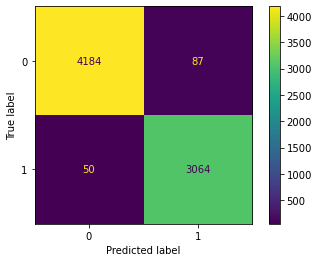

In [17]:
y_train_pred_lgbmc = lgbmc.predict(X_train)
y_test_pred_lgbmc = lgbmc.predict(X_test)
print('LightGBM Classifier:')
print('-' * 100)
print('Train accuracy_score: ', accuracy_score(y_train, y_train_pred_lgbmc))
print('Test accuracy_score: ', accuracy_score(y_test, y_test_pred_lgbmc))
print('-' * 100)
print('Train f1_score: ', f1_score(y_train, y_train_pred_lgbmc))
print('Test f1_score: ', f1_score(y_test, y_test_pred_lgbmc))
print('-' * 100)
print('Train precision_score: ', precision_score(y_train, y_train_pred_lgbmc))
print('Test precision_score: ', precision_score(y_test, y_test_pred_lgbmc))
print('-' * 100)
print('Train recall_score: ', recall_score(y_train, y_train_pred_lgbmc))
print('Test recall_score: ', recall_score(y_test, y_test_pred_lgbmc))
plot_confusion_matrix(lgbmc, X_test, y_test)

In [18]:
file = open('classifier.pkl', 'wb')
pickle.dump(lgbmc, file)
file.close()

In [21]:
percentage = lgbmc.predict_proba(X_test)

In [23]:
percentage = [i[1] for i in percentage]

In [26]:
tdf = X_test
tdf['actual'] = y_test
tdf['predicted'] = y_test_pred_lgbmc
tdf['percentage'] = percentage

In [27]:
tdf.to_csv('2ndTEMPDATA.csv', index = None)

In [28]:
cbc = CatBoostClassifier()
cbc.fit(X_train, y_train)

Learning rate set to 0.061826
0:	learn: 0.6552706	total: 159ms	remaining: 2m 39s
1:	learn: 0.6217112	total: 170ms	remaining: 1m 24s
2:	learn: 0.5942436	total: 179ms	remaining: 59.6s
3:	learn: 0.5694061	total: 190ms	remaining: 47.3s
4:	learn: 0.5499512	total: 199ms	remaining: 39.6s
5:	learn: 0.5329674	total: 209ms	remaining: 34.5s
6:	learn: 0.5180695	total: 218ms	remaining: 30.9s
7:	learn: 0.5048417	total: 227ms	remaining: 28.2s
8:	learn: 0.4939259	total: 237ms	remaining: 26.1s
9:	learn: 0.4836442	total: 246ms	remaining: 24.4s
10:	learn: 0.4749348	total: 256ms	remaining: 23s
11:	learn: 0.4675450	total: 265ms	remaining: 21.8s
12:	learn: 0.4615540	total: 274ms	remaining: 20.8s
13:	learn: 0.4546704	total: 284ms	remaining: 20s
14:	learn: 0.4496103	total: 292ms	remaining: 19.2s
15:	learn: 0.4437760	total: 301ms	remaining: 18.5s
16:	learn: 0.4385397	total: 310ms	remaining: 17.9s
17:	learn: 0.4342269	total: 319ms	remaining: 17.4s
18:	learn: 0.4282027	total: 328ms	remaining: 17s
19:	learn: 0.42

164:	learn: 0.1586103	total: 1.71s	remaining: 8.64s
165:	learn: 0.1566686	total: 1.72s	remaining: 8.63s
166:	learn: 0.1559746	total: 1.73s	remaining: 8.62s
167:	learn: 0.1555916	total: 1.74s	remaining: 8.6s
168:	learn: 0.1542543	total: 1.75s	remaining: 8.59s
169:	learn: 0.1531668	total: 1.76s	remaining: 8.57s
170:	learn: 0.1526640	total: 1.77s	remaining: 8.56s
171:	learn: 0.1519162	total: 1.77s	remaining: 8.55s
172:	learn: 0.1508992	total: 1.79s	remaining: 8.54s
173:	learn: 0.1500253	total: 1.79s	remaining: 8.53s
174:	learn: 0.1497208	total: 1.8s	remaining: 8.51s
175:	learn: 0.1490344	total: 1.81s	remaining: 8.5s
176:	learn: 0.1484464	total: 1.82s	remaining: 8.48s
177:	learn: 0.1475650	total: 1.83s	remaining: 8.47s
178:	learn: 0.1469363	total: 1.84s	remaining: 8.46s
179:	learn: 0.1467284	total: 1.85s	remaining: 8.45s
180:	learn: 0.1459828	total: 1.86s	remaining: 8.43s
181:	learn: 0.1446562	total: 1.87s	remaining: 8.42s
182:	learn: 0.1436819	total: 1.88s	remaining: 8.41s
183:	learn: 0.1

326:	learn: 0.0646292	total: 3.26s	remaining: 6.71s
327:	learn: 0.0643080	total: 3.27s	remaining: 6.7s
328:	learn: 0.0640234	total: 3.28s	remaining: 6.69s
329:	learn: 0.0637324	total: 3.29s	remaining: 6.68s
330:	learn: 0.0632972	total: 3.3s	remaining: 6.66s
331:	learn: 0.0631219	total: 3.31s	remaining: 6.65s
332:	learn: 0.0629039	total: 3.31s	remaining: 6.64s
333:	learn: 0.0625134	total: 3.33s	remaining: 6.63s
334:	learn: 0.0622874	total: 3.33s	remaining: 6.62s
335:	learn: 0.0619423	total: 3.34s	remaining: 6.61s
336:	learn: 0.0617604	total: 3.35s	remaining: 6.6s
337:	learn: 0.0614496	total: 3.36s	remaining: 6.58s
338:	learn: 0.0612811	total: 3.37s	remaining: 6.57s
339:	learn: 0.0610859	total: 3.38s	remaining: 6.56s
340:	learn: 0.0608961	total: 3.39s	remaining: 6.55s
341:	learn: 0.0606647	total: 3.4s	remaining: 6.54s
342:	learn: 0.0603736	total: 3.41s	remaining: 6.53s
343:	learn: 0.0600252	total: 3.42s	remaining: 6.51s
344:	learn: 0.0597225	total: 3.43s	remaining: 6.5s
345:	learn: 0.059

492:	learn: 0.0315313	total: 4.82s	remaining: 4.96s
493:	learn: 0.0314223	total: 4.83s	remaining: 4.95s
494:	learn: 0.0312928	total: 4.84s	remaining: 4.94s
495:	learn: 0.0312565	total: 4.85s	remaining: 4.93s
496:	learn: 0.0311407	total: 4.86s	remaining: 4.92s
497:	learn: 0.0309197	total: 4.87s	remaining: 4.91s
498:	learn: 0.0308274	total: 4.88s	remaining: 4.9s
499:	learn: 0.0307799	total: 4.89s	remaining: 4.89s
500:	learn: 0.0307186	total: 4.9s	remaining: 4.88s
501:	learn: 0.0305591	total: 4.91s	remaining: 4.87s
502:	learn: 0.0304344	total: 4.92s	remaining: 4.86s
503:	learn: 0.0303079	total: 4.93s	remaining: 4.85s
504:	learn: 0.0301328	total: 4.94s	remaining: 4.84s
505:	learn: 0.0300311	total: 4.95s	remaining: 4.83s
506:	learn: 0.0299001	total: 4.96s	remaining: 4.82s
507:	learn: 0.0297445	total: 4.97s	remaining: 4.81s
508:	learn: 0.0296504	total: 4.98s	remaining: 4.8s
509:	learn: 0.0295317	total: 4.99s	remaining: 4.79s
510:	learn: 0.0294274	total: 5s	remaining: 4.78s
511:	learn: 0.0293

668:	learn: 0.0166030	total: 6.53s	remaining: 3.23s
669:	learn: 0.0165550	total: 6.54s	remaining: 3.22s
670:	learn: 0.0165057	total: 6.55s	remaining: 3.21s
671:	learn: 0.0164423	total: 6.56s	remaining: 3.2s
672:	learn: 0.0163973	total: 6.57s	remaining: 3.19s
673:	learn: 0.0162504	total: 6.58s	remaining: 3.18s
674:	learn: 0.0162049	total: 6.58s	remaining: 3.17s
675:	learn: 0.0161790	total: 6.59s	remaining: 3.16s
676:	learn: 0.0161558	total: 6.6s	remaining: 3.15s
677:	learn: 0.0160817	total: 6.61s	remaining: 3.14s
678:	learn: 0.0160425	total: 6.62s	remaining: 3.13s
679:	learn: 0.0159657	total: 6.63s	remaining: 3.12s
680:	learn: 0.0159068	total: 6.64s	remaining: 3.11s
681:	learn: 0.0158332	total: 6.65s	remaining: 3.1s
682:	learn: 0.0157893	total: 6.66s	remaining: 3.09s
683:	learn: 0.0157482	total: 6.66s	remaining: 3.08s
684:	learn: 0.0156942	total: 6.67s	remaining: 3.07s
685:	learn: 0.0156562	total: 6.68s	remaining: 3.06s
686:	learn: 0.0156215	total: 6.69s	remaining: 3.05s
687:	learn: 0.0

837:	learn: 0.0099898	total: 8.09s	remaining: 1.56s
838:	learn: 0.0099664	total: 8.1s	remaining: 1.55s
839:	learn: 0.0099432	total: 8.11s	remaining: 1.54s
840:	learn: 0.0099206	total: 8.12s	remaining: 1.53s
841:	learn: 0.0098981	total: 8.13s	remaining: 1.52s
842:	learn: 0.0098728	total: 8.14s	remaining: 1.52s
843:	learn: 0.0098366	total: 8.15s	remaining: 1.51s
844:	learn: 0.0098135	total: 8.16s	remaining: 1.5s
845:	learn: 0.0097984	total: 8.17s	remaining: 1.49s
846:	learn: 0.0097727	total: 8.18s	remaining: 1.48s
847:	learn: 0.0097436	total: 8.19s	remaining: 1.47s
848:	learn: 0.0097187	total: 8.2s	remaining: 1.46s
849:	learn: 0.0096953	total: 8.21s	remaining: 1.45s
850:	learn: 0.0096611	total: 8.22s	remaining: 1.44s
851:	learn: 0.0096361	total: 8.23s	remaining: 1.43s
852:	learn: 0.0096122	total: 8.24s	remaining: 1.42s
853:	learn: 0.0095958	total: 8.25s	remaining: 1.41s
854:	learn: 0.0095693	total: 8.26s	remaining: 1.4s
855:	learn: 0.0095182	total: 8.27s	remaining: 1.39s
856:	learn: 0.00

999:	learn: 0.0066395	total: 9.63s	remaining: 0us


Cat Boost Classifier:
----------------------------------------------------------------------------------------------------
Train accuracy_score:  0.9999849535817998
Test accuracy_score:  1.0
----------------------------------------------------------------------------------------------------
Train f1_score:  0.9999820997046451
Test f1_score:  1.0
----------------------------------------------------------------------------------------------------
Train precision_score:  1.0
Test precision_score:  1.0
----------------------------------------------------------------------------------------------------
Train recall_score:  0.9999642000501199
Test recall_score:  1.0


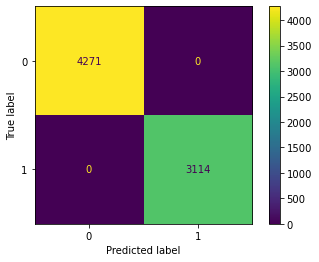

In [29]:
y_train_pred_cbc = cbc.predict(X_train)
y_test_pred_cbc = cbc.predict(X_test)
print('Cat Boost Classifier:')
print('-' * 100)
print('Train accuracy_score: ', accuracy_score(y_train, y_train_pred_cbc))
print('Test accuracy_score: ', accuracy_score(y_test, y_test_pred_cbc))
print('-' * 100)
print('Train f1_score: ', f1_score(y_train, y_train_pred_cbc))
print('Test f1_score: ', f1_score(y_test, y_test_pred_cbc))
print('-' * 100)
print('Train precision_score: ', precision_score(y_train, y_train_pred_cbc))
print('Test precision_score: ', precision_score(y_test, y_test_pred_cbc))
print('-' * 100)
print('Train recall_score: ', recall_score(y_train, y_train_pred_cbc))
print('Test recall_score: ', recall_score(y_test, y_test_pred_cbc))
plot_confusion_matrix(cbc, X_test, y_test)

In [30]:
percentage = cbc.predict_proba(X_test)

percentage = [i[1] for i in percentage]

tdf = X_test
tdf['actual'] = y_test
tdf['predicted'] = y_test_pred_cbc
tdf['percentage'] = percentage

tdf.to_csv('2ndTEMPDATAcbc.csv', index = None)